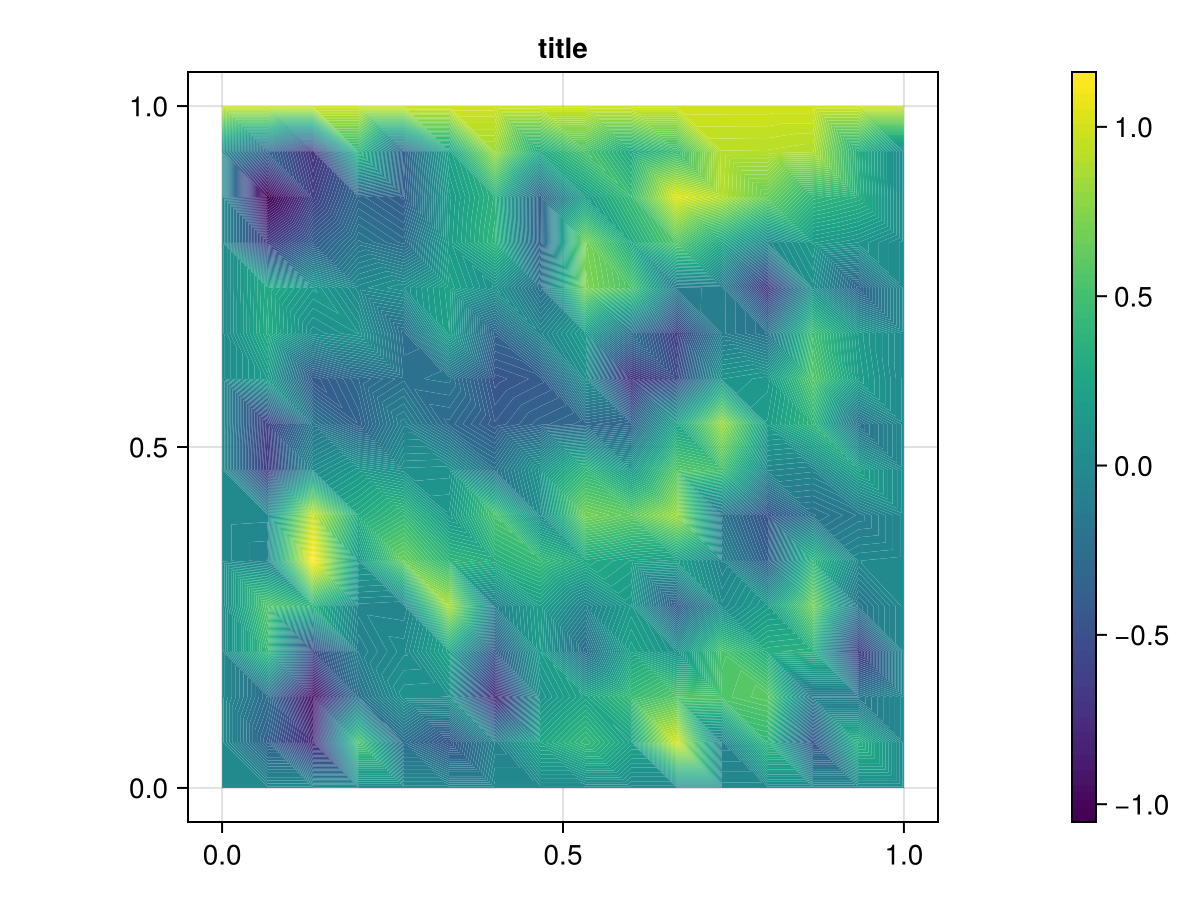

In [4]:
include("MMfem.jl")

#genero la malla
mesh = rectangle_mesh(0,1,0,1,16)
p,t,b = mesh_data(mesh) 


#datos
μ = 1
f(v) = [0,0]

#reservo el espacio de solucion
uₕ = zeros(2*size(p,1),1)
pₕ = zeros(size(p,1),1)

NodesFree = setdiff(1:size(p)[1],b)

#incorporo dato de borde
function u₀(X,componente)
    
    l = length(X[:,1])
    u = zeros(l)
    if componente==1
        for j=1:l
            if X[:,2][j]==1
                u[j]=1
            elseif X[:,2][j]==0
                u[j]=0
            elseif X[:,1][j]==1
                u[j]=0
            elseif X[:,1][j]==0
                u[j]=0
            end
        end
        return u
    else
        for j=1:l
            if X[:,2][j]==1
                u[j]=0
            elseif X[:,2][j]==0
                u[j]=0
            elseif X[:,1][j]==1
                u[j]=0
            elseif X[:,1][j]==0
                u[j]=0
            end
        return u
        end
    end
end

X=p[b,:]
uₕ[b]=u₀(X,1) #componente 1
uₕ[b.+size(p)[1]]=u₀(X,2) #componente 2
            


#Matrix Assamble

A = μ*Stiffnes_Δ(mesh)
Bx,By = Stiffnes_div(mesh)
G = Stiffnes_G(mesh)

K₀ = [A spzeros(size(p)[1],size(p)[1]) -Bx';spzeros(size(p)[1],size(p)[1]) A -By';-Bx -By -G]
#uₕ_1 = uₕ[1:size(p,1)]
#uₕ_2 = uₕ[size(p,1)+1:2*size(p,1)]

F₀ = LoadVector(f,mesh)

#Fijamos nodo de la presión para incorporar promedio 0
node_p = NodesFree[1]
NodesFree_p = setdiff(1:size(p,1),node_p)
pₕ[node_p] = 0

F₀ = F₀ - K₀*[uₕ;pₕ]

#armo matriz de rigidez
K = [A[NodesFree,NodesFree] spzeros(length(NodesFree),length(NodesFree)) -Bx[NodesFree_p,NodesFree]'; 
    spzeros(length(NodesFree),length(NodesFree)) A[NodesFree,NodesFree] -By[NodesFree_p,NodesFree]';
    -Bx[NodesFree_p,NodesFree] -By[NodesFree_p,NodesFree] G[NodesFree_p,NodesFree_p]]

F1 = F₀[NodesFree]
F2 = F₀[NodesFree.+size(p)[1]]
F3 = F₀[NodesFree_p.+2*size(p)[1]] 
F = [F1;F2;F3]

K = Matrix(K)

sol = K\F
uₕ[NodesFree] = sol[1:length(NodesFree)]
uₕ[NodesFree.+size(p)[1]] = sol[length(NodesFree)+1:2*length(NodesFree)]  

Uₕ = [uₕ[1:size(p,1)] uₕ[size(p,1)+1:2*size(p,1)]]

scalar_plot(uₕ[1:size(p,1)],mesh)